In [28]:
from sklearn.model_selection import train_test_split
from experiment import tune_architecture, tune_hyperparameters, train_final_model
from model import predict
import pandas as pd
import torch
import preprocessing
import numpy as np

# Data preprocessing
## Assign labels

In [2]:
df = pd.read_csv("train_data.csv")
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Check for duplicated rows

In [3]:
df.duplicated().sum()

np.int64(307)

In [4]:
df["Label"] = df["SalePrice"].apply(preprocessing.classify)
df = df.drop(columns=["SalePrice"])
df.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),Label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0


## Check for missing values

In [5]:
preprocessing.missing(df, df.columns)

{}

# Categorical data

In [6]:
numeric_columns = df._get_numeric_data().columns
categorical_columns = list(set(df.columns) - set(numeric_columns))
numeric_columns = list(set(numeric_columns) - {'Label'})

In [7]:
categorical_unique = preprocessing.unique(df, categorical_columns)

In [8]:
numeric_unique = preprocessing.unique(df, numeric_columns)

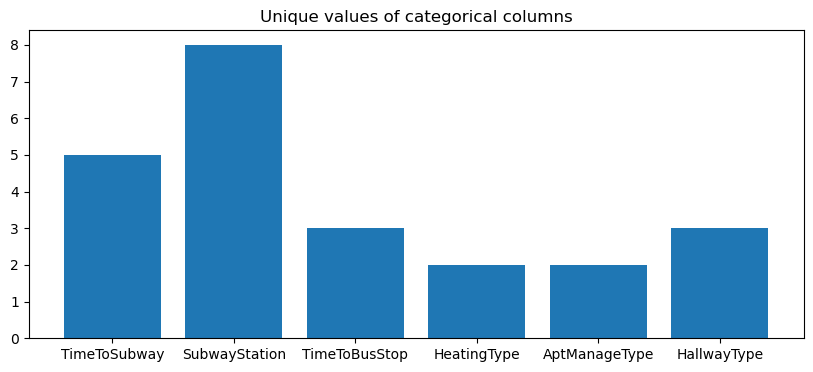

In [9]:
preprocessing.plot_bar(categorical_unique, "Unique values of categorical columns")

In [10]:
counts_by_label = dict(df["Label"].value_counts())
label_assignment = {0: "cheap (0)", 1:"average (1)", 2:"expensive (2)"}
counts_by_label = {label_assignment[key]: val for key, val in counts_by_label.items()}

In [11]:
ordinal_columns = ["TimeToBusStop", "TimeToSubway"]
nominal_columns = list(set(categorical_columns) - set(ordinal_columns))

## Check for outliers 

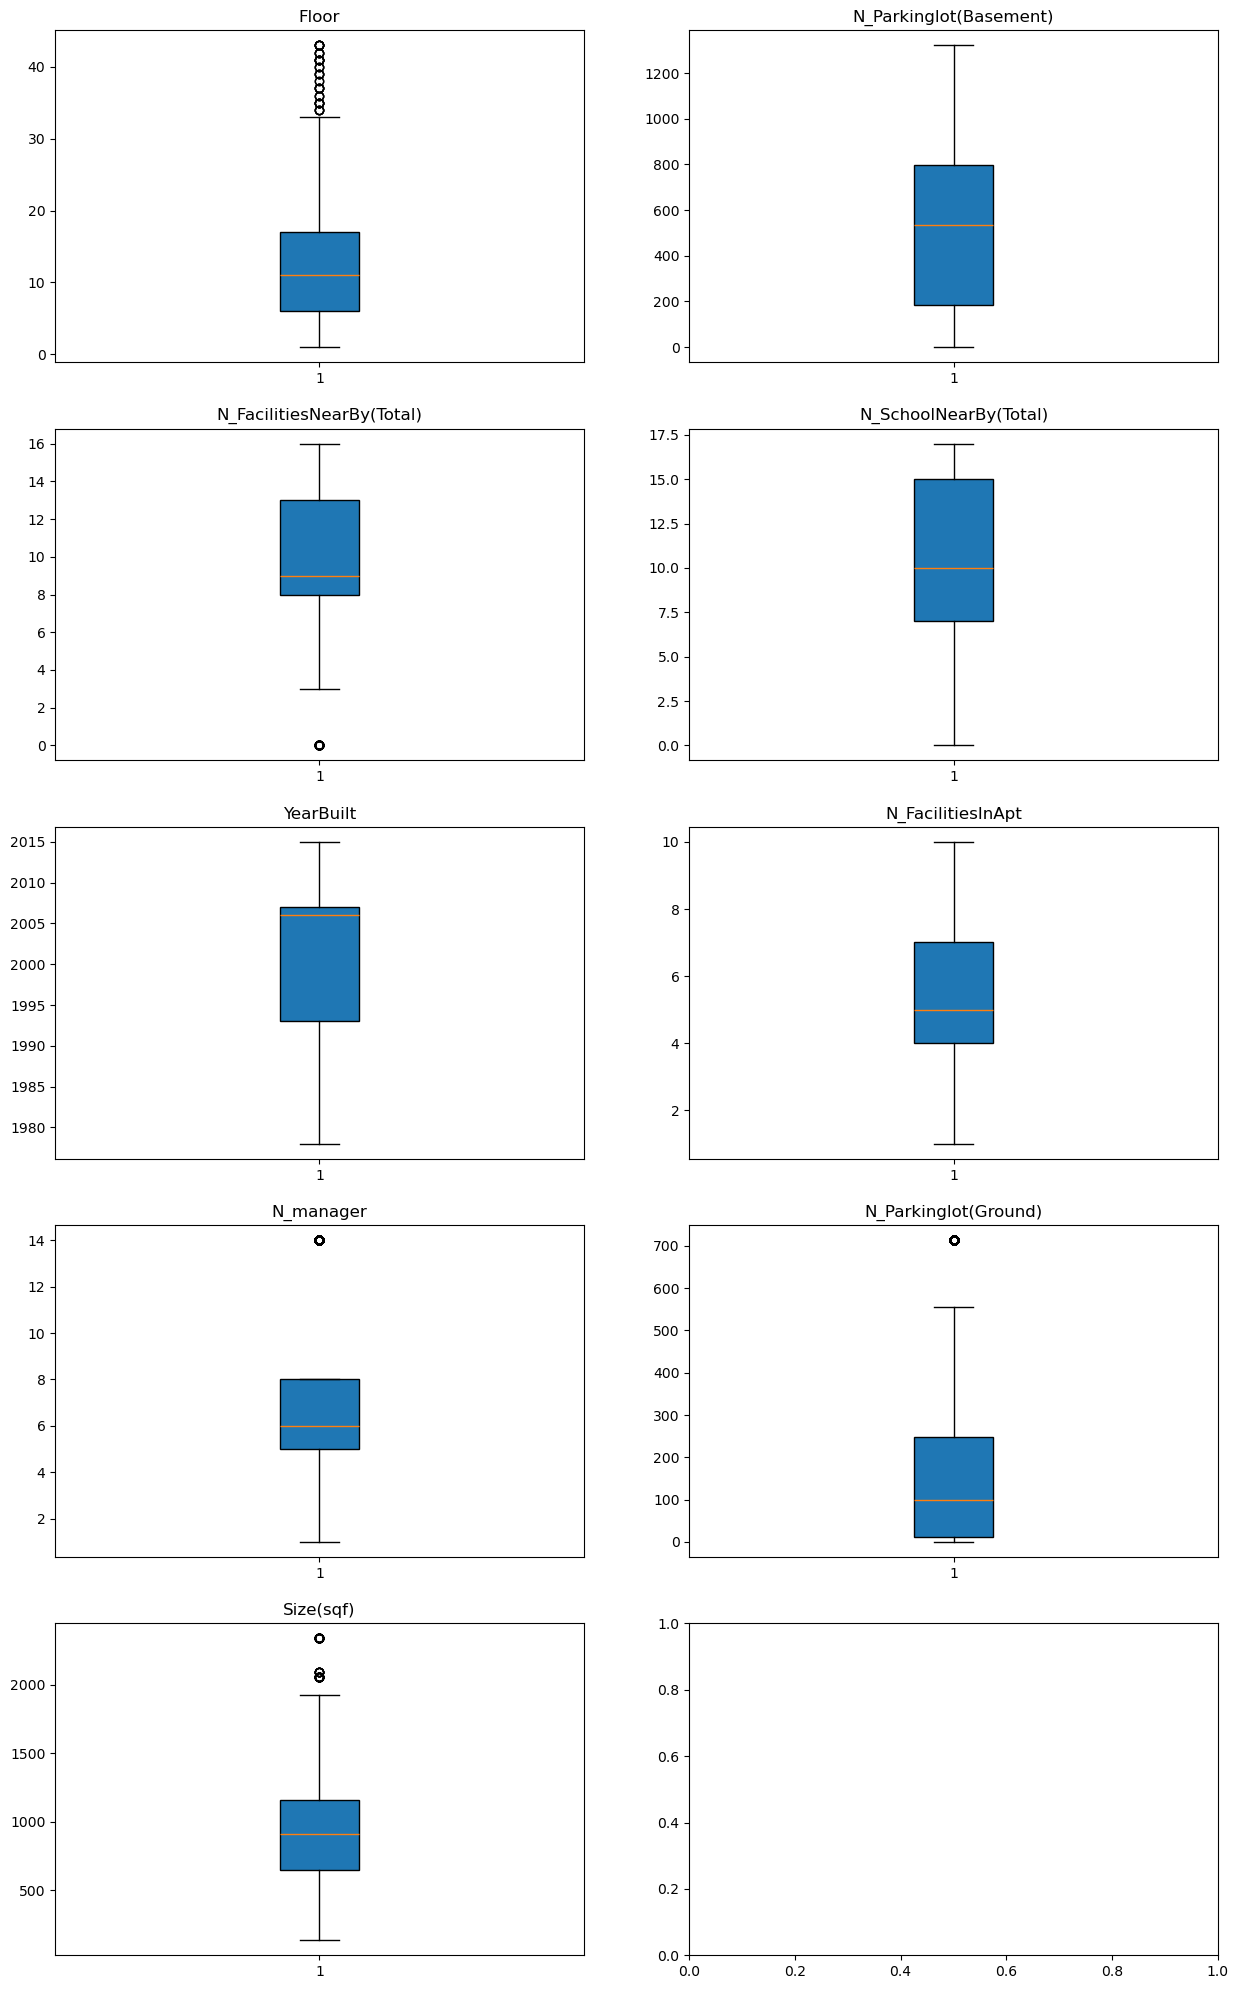

In [12]:
preprocessing.plot_boxplot(df, numeric_columns)

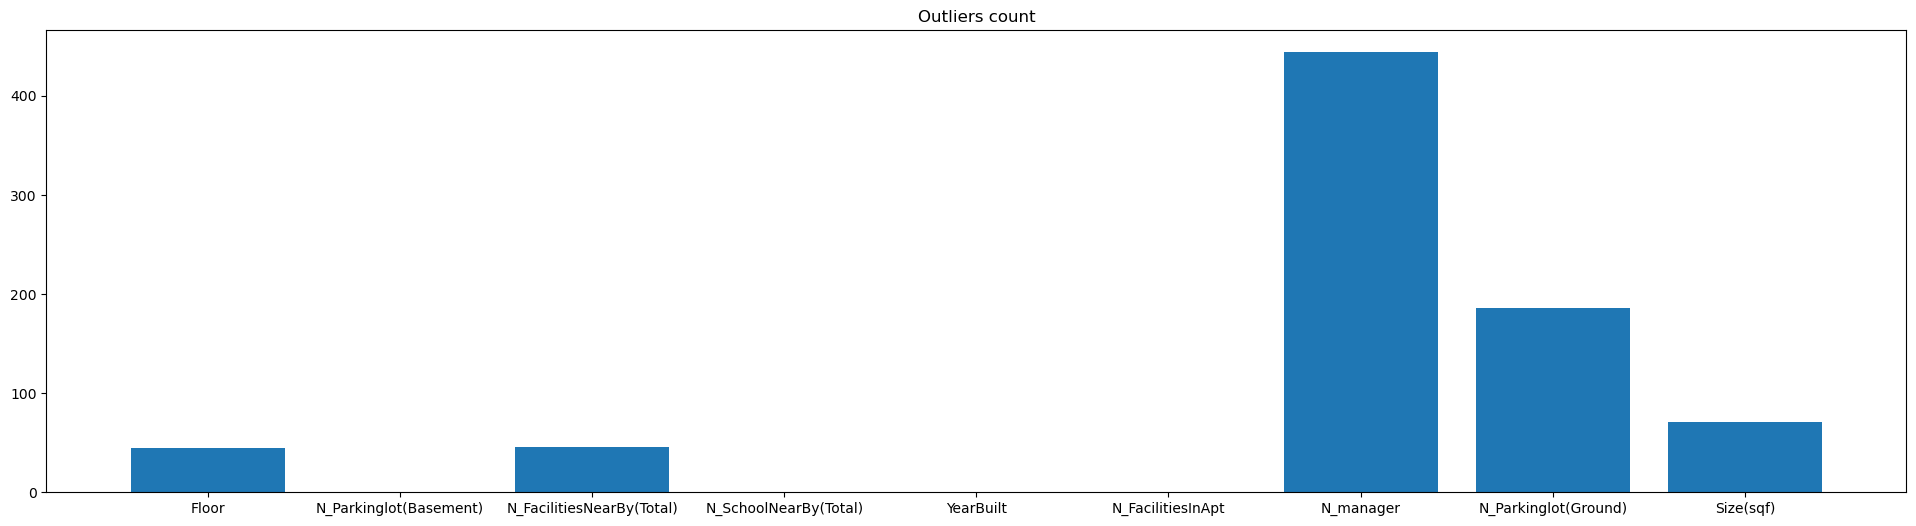

In [13]:
outliers_counts, outliers = preprocessing.check_outliers(df, numeric_columns)
preprocessing.plot_bar(outliers_counts, "Outliers count", size=(24, 6))

## Analyze if some features have normal distribution

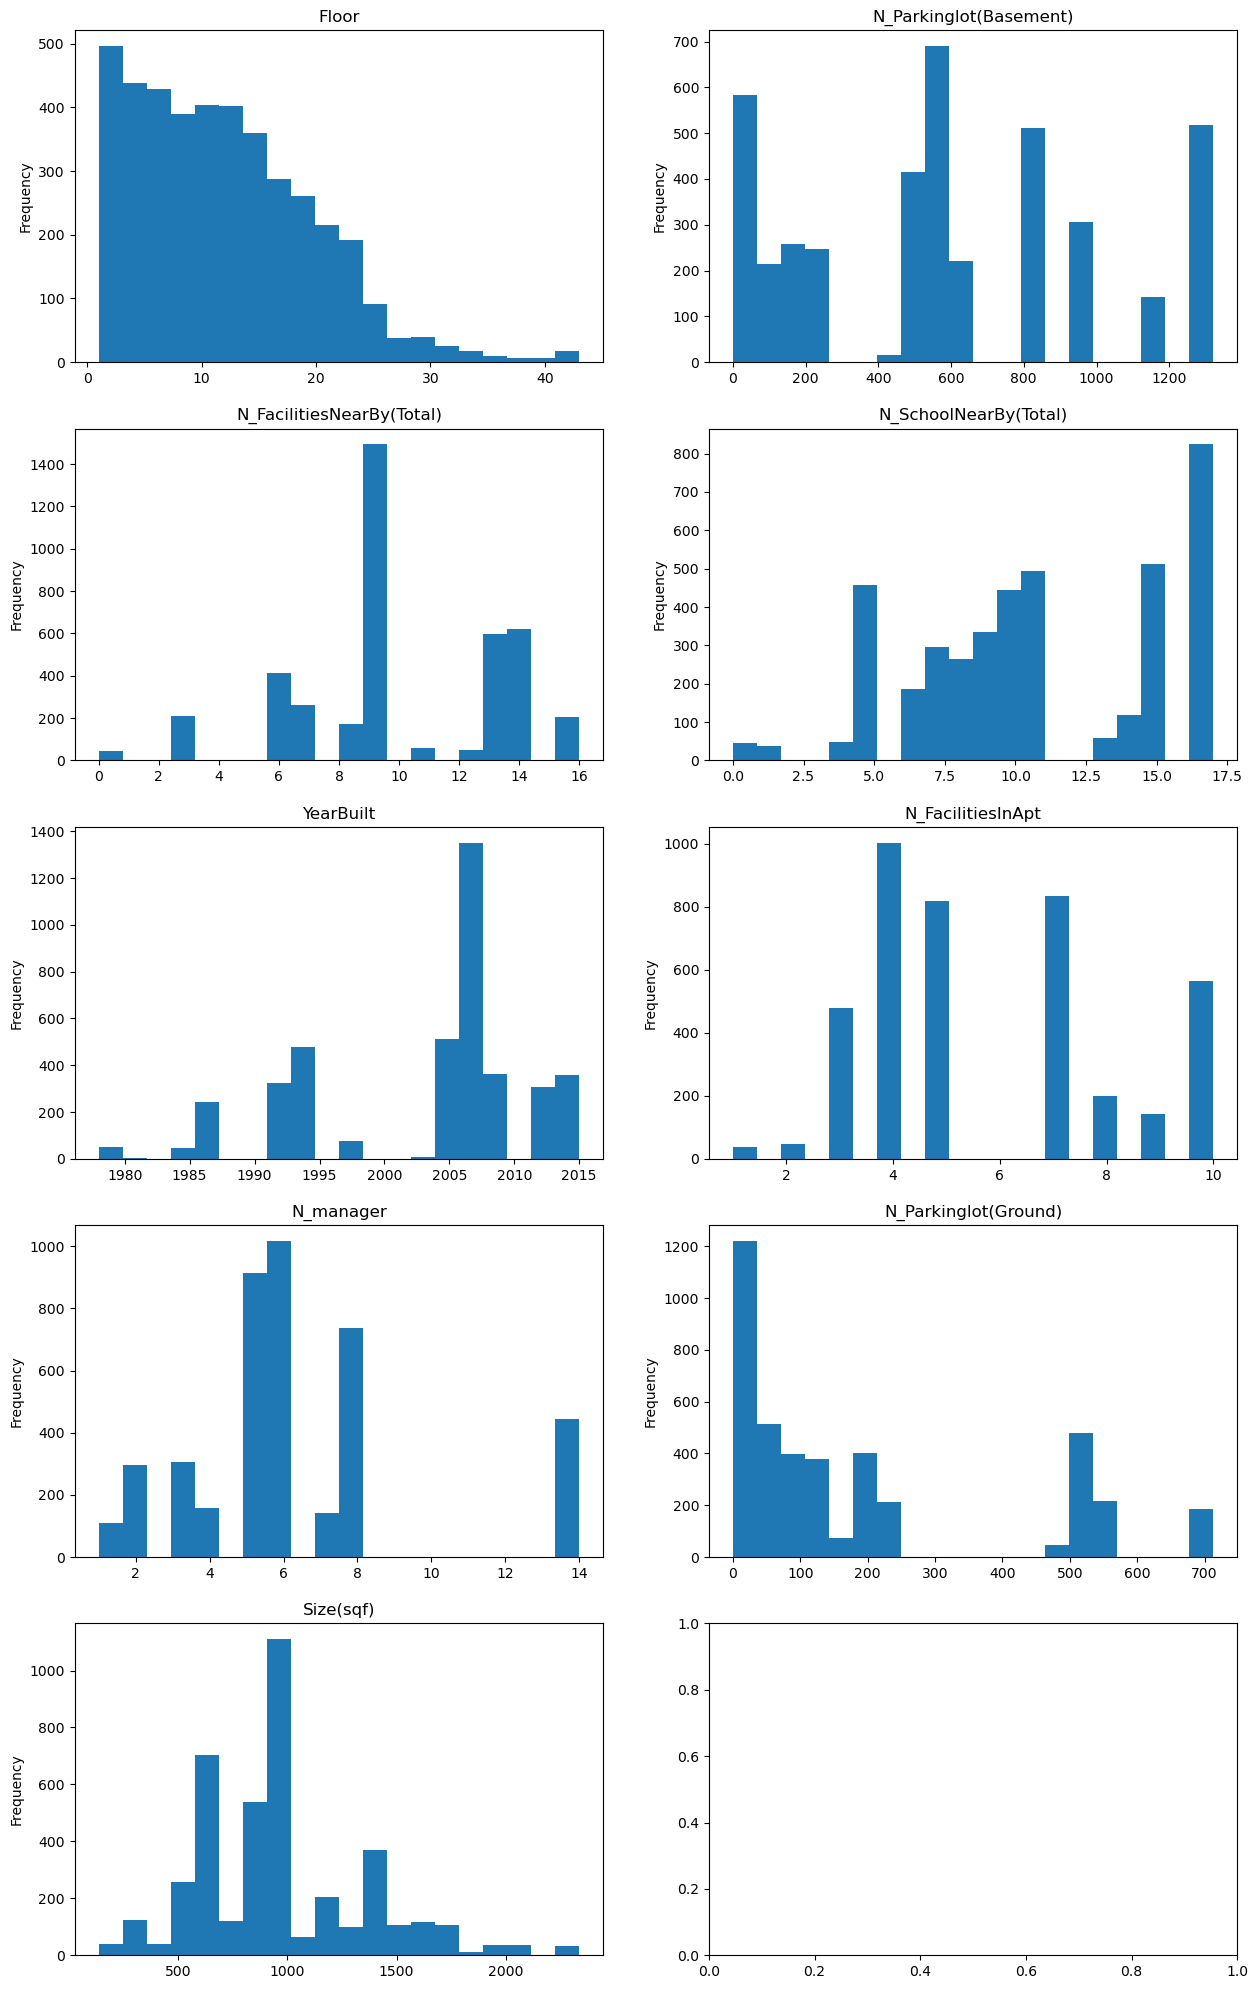

In [14]:
preprocessing.plot_histograms(df, numeric_columns)

In [15]:
preprocessing.shapiro_wilk(df, numeric_columns)

{'Floor': 'not normally distributed',
 'N_Parkinglot(Basement)': 'not normally distributed',
 'N_FacilitiesNearBy(Total)': 'not normally distributed',
 'N_SchoolNearBy(Total)': 'not normally distributed',
 'YearBuilt': 'not normally distributed',
 'N_FacilitiesInApt': 'not normally distributed',
 'N_manager': 'not normally distributed',
 'N_Parkinglot(Ground)': 'not normally distributed',
 'Size(sqf)': 'not normally distributed'}

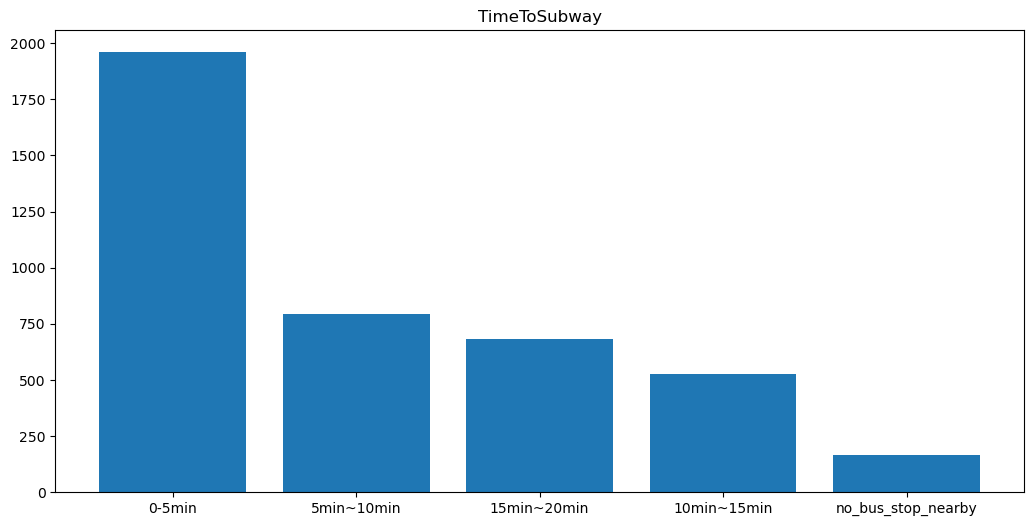

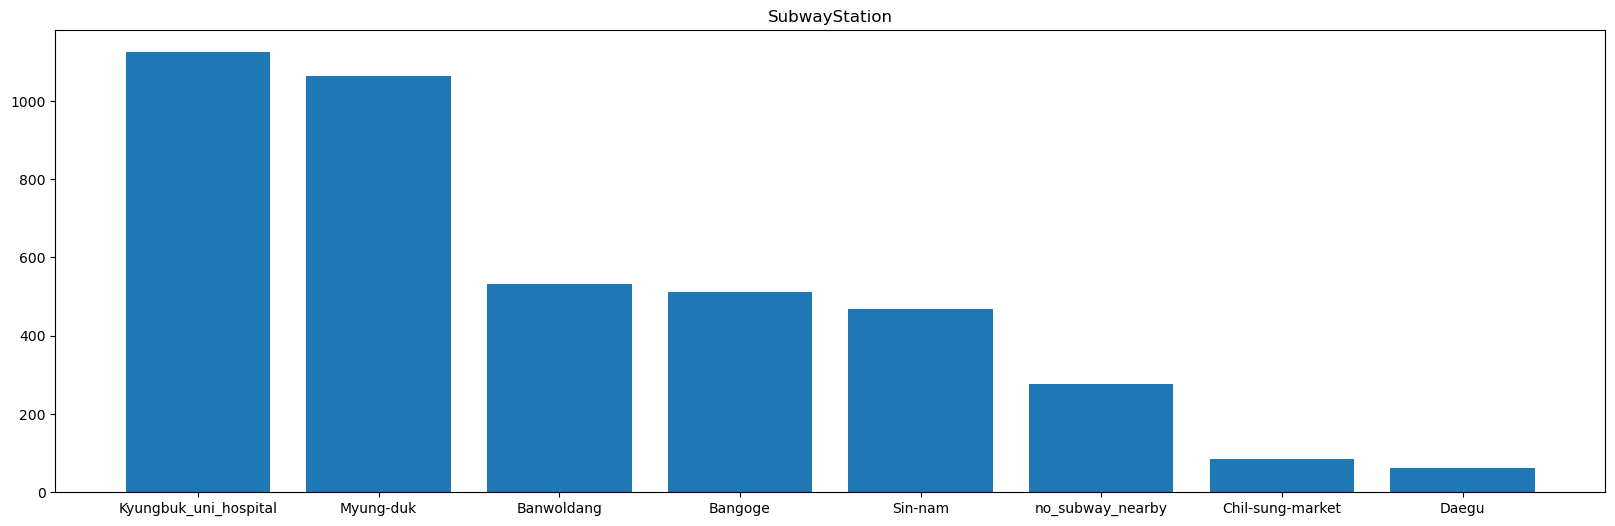

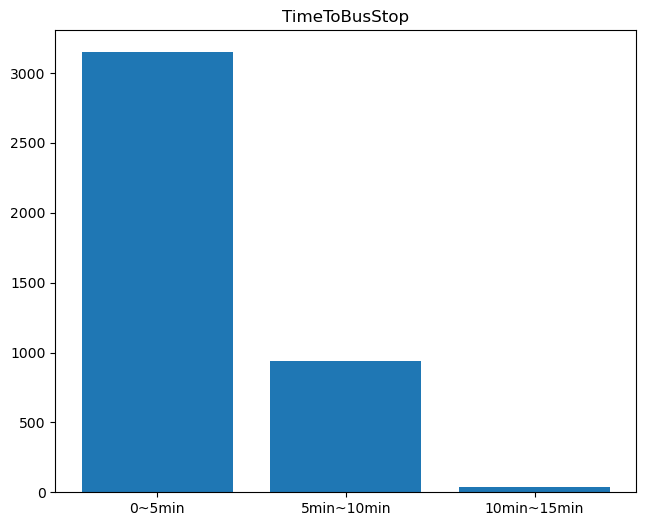

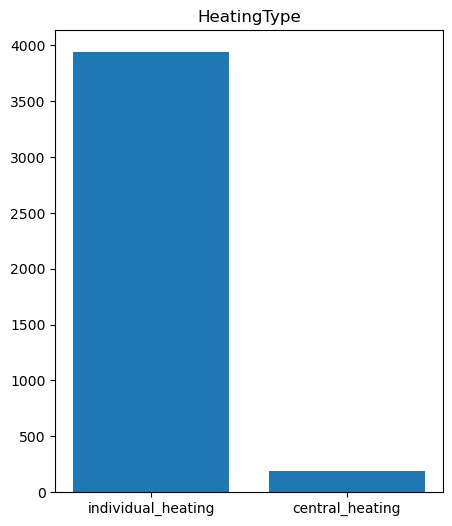

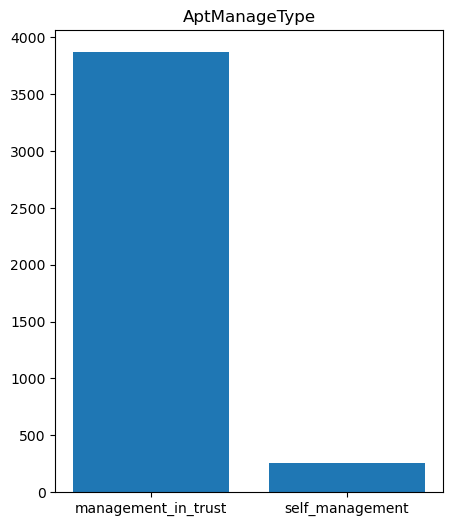

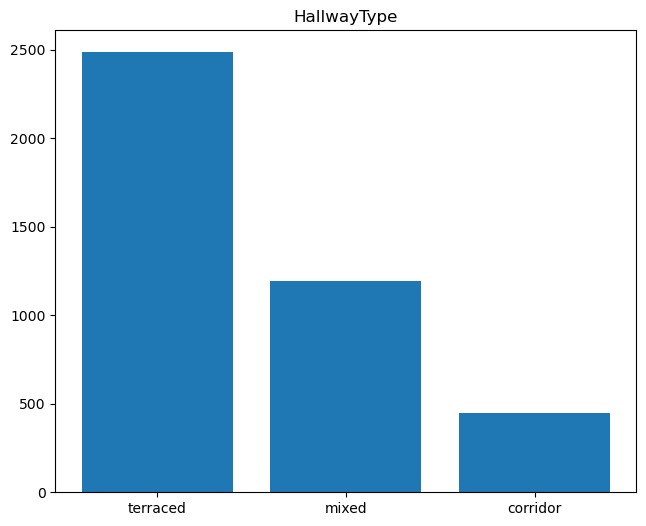

In [16]:
for col in categorical_columns:
    preprocessing.plot_bar(df[col].value_counts(), col, size=(2.5*len(df[col].value_counts()), 6))

## Analyzing the data imbalance

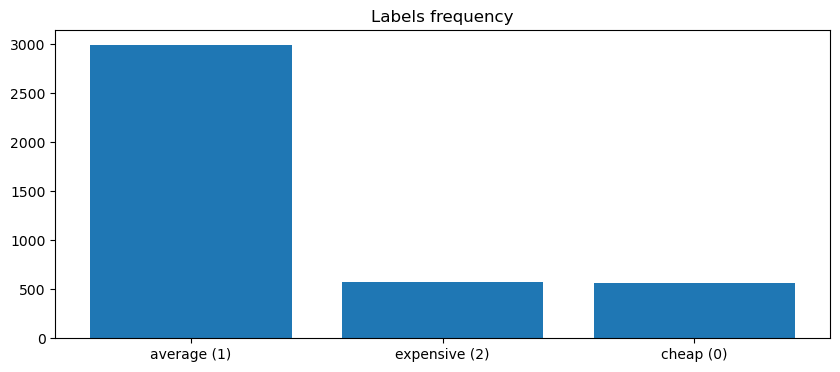

In [17]:
preprocessing.plot_bar(counts_by_label, "Labels frequency")

In [18]:
y = df["Label"].to_numpy()
X = df.drop(columns=["Label"])
X = preprocessing.preprocess(X, numeric_columns, ordinal_columns, nominal_columns)
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2)

In [19]:
weights = preprocessing.calculate_class_weights(train_y)
weights

tensor([2.4222, 0.4615, 2.3802])

# Model and training

In [20]:
architectures = [
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None}
train_accuracy, train_precision, train_recall, train_f1, val_accuracy, val_precision, val_recall, val_f1 = tune_architecture(train_x, train_y, val_x, val_y, architectures, training_setup, device)

Training model 0
Epoch: 0, loss: 1.2784517120856504
Epoch: 1, loss: 0.887850712125118
Epoch: 2, loss: 0.6969511394317334
Epoch: 3, loss: 0.5958569284815055
Epoch: 4, loss: 0.534084341273858
Epoch: 5, loss: 0.49189481483055997
Epoch: 6, loss: 0.46945907404789555
Epoch: 7, loss: 0.4433402275809875
Epoch: 8, loss: 0.4329789068836432
Epoch: 9, loss: 0.4173370204292811
Epoch: 10, loss: 0.4067491482083614
Epoch: 11, loss: 0.39918154306136644
Epoch: 12, loss: 0.3902694909618451
Epoch: 13, loss: 0.38893882070596403
Epoch: 14, loss: 0.3795308717168294
Epoch: 15, loss: 0.36545564750066173
Epoch: 16, loss: 0.36522841166991454
Epoch: 17, loss: 0.36078210920095444
Epoch: 18, loss: 0.3579291056555051
Epoch: 19, loss: 0.356059731485752
Epoch: 20, loss: 0.3472224903794435
Epoch: 21, loss: 0.3448228555229994
Epoch: 22, loss: 0.34066164837433743
Epoch: 23, loss: 0.33974579119911563
Epoch: 24, loss: 0.33797239454892963
Epoch: 25, loss: 0.3342023878716506
Epoch: 26, loss: 0.3351505155173632
Epoch: 27, los

In [21]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.864504,0.864504,0.864504,0.864504,0.866667,0.866667,0.866667,0.866667
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.866626,0.866626,0.866626,0.866626,0.864242,0.864242,0.864242,0.864242
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.863292,0.863292,0.863292,0.863292,0.861818,0.861818,0.861818,0.861818
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.845105,0.845105,0.845105,0.845105,0.837576,0.837576,0.837576,0.837576
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.849651,0.849651,0.849651,0.849651,0.836364,0.836364,0.836364,0.836364
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.839345,0.839345,0.839345,0.839345,0.829091,0.829091,0.829091,0.829091


In [34]:
hyperparameters = [
    {"epochs": 60, "lr": 3e-2, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-2, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 128, "class_weights": None},
    ]
train_accuracy, train_precision, train_recall, train_f1, val_accuracy, val_precision, val_recall, val_f1 = tune_hyperparameters(train_x, train_y, val_x, val_y, architectures[0], hyperparameters, device)

Training model 0
Epoch: 0, loss: 0.47201047035364
Epoch: 1, loss: 0.3665316543326928
Epoch: 2, loss: 0.3581112041496314
Epoch: 3, loss: 0.347305308167751
Epoch: 4, loss: 0.3311964709025163
Epoch: 5, loss: 0.33711942829764807
Epoch: 6, loss: 0.31836553233174175
Epoch: 7, loss: 0.32410048292233395
Epoch: 8, loss: 0.31460312180794203
Epoch: 9, loss: 0.3052342301951005
Epoch: 10, loss: 0.30219851663479436
Epoch: 11, loss: 0.3051078087435319
Epoch: 12, loss: 0.30649744690610814
Epoch: 13, loss: 0.3081116544512602
Epoch: 14, loss: 0.29271438545905626
Epoch: 15, loss: 0.30382312117860866
Epoch: 16, loss: 0.29985899650133574
Epoch: 17, loss: 0.292389187675256
Epoch: 18, loss: 0.2930486471607135
Epoch: 19, loss: 0.3011754974722862
Epoch: 20, loss: 0.3025439576460765
Epoch: 21, loss: 0.30398265902812666
Epoch: 22, loss: 0.28958483040332794
Epoch: 23, loss: 0.2941191296737928
Epoch: 24, loss: 0.290563385360516
Epoch: 25, loss: 0.29112365641272986
Epoch: 26, loss: 0.29176666329686457
Epoch: 27, lo

In [35]:
hyperparameters_results = pd.DataFrame({"models": [architectures[0]]*len(hyperparameters), "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
hyperparameters_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.857533,0.857533,0.857533,0.857533,0.869091,0.869091,0.869091,0.869091
1,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.861473,0.861473,0.861473,0.861473,0.861818,0.861818,0.861818,0.861818
2,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.869961,0.869961,0.869961,0.869961,0.864242,0.864242,0.864242,0.864242
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.866626,0.866626,0.866626,0.866626,0.866667,0.866667,0.866667,0.866667
4,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.864504,0.864504,0.864504,0.864504,0.865455,0.865455,0.865455,0.865455
5,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.863898,0.863898,0.863898,0.863898,0.870303,0.870303,0.870303,0.870303
6,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.832980,0.832980,0.832980,0.832980,0.832727,0.832727,0.832727,0.832727
7,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.828433,0.828433,0.828433,0.828433,0.833939,0.833939,0.833939,0.833939


# Predict on test data

In [37]:
final_model = train_final_model(train_x, train_y, architectures[0], hyperparameters[5], device)

Training final model
Epoch: 0, loss: 1.9587016839247484
Epoch: 1, loss: 1.651204297175774
Epoch: 2, loss: 1.4334560861954322
Epoch: 3, loss: 1.2641202027981098
Epoch: 4, loss: 1.1202366397931025
Epoch: 5, loss: 1.002948297904088
Epoch: 6, loss: 0.908316962994062
Epoch: 7, loss: 0.8283208998349997
Epoch: 8, loss: 0.7635554464963766
Epoch: 9, loss: 0.7114469523613269
Epoch: 10, loss: 0.6674998631844153
Epoch: 11, loss: 0.630082524739779
Epoch: 12, loss: 0.6033004270150111
Epoch: 13, loss: 0.5767141763980572
Epoch: 14, loss: 0.5515355032223922
Epoch: 15, loss: 0.5341273156496195
Epoch: 16, loss: 0.5189411651629668
Epoch: 17, loss: 0.5006537861548938
Epoch: 18, loss: 0.4864311619446828
Epoch: 19, loss: 0.470583696778004
Epoch: 20, loss: 0.45925025183420914
Epoch: 21, loss: 0.4497847178807625
Epoch: 22, loss: 0.4370963309819882
Epoch: 23, loss: 0.4308901887673598
Epoch: 24, loss: 0.4213899259383862
Epoch: 25, loss: 0.413100187595074
Epoch: 26, loss: 0.4049220039294316
Epoch: 27, loss: 0.398

In [38]:
df_test = pd.read_csv("test_data.csv")
test_x = preprocessing.preprocess(df_test, numeric_columns, ordinal_columns, nominal_columns)

In [39]:
test_preds = predict(final_model, test_x)
np.savetxt("preds.csv", test_preds, delimiter=",", fmt='%d')

# Conclusions